# DC2 Playground

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib

In [3]:
import torch
import torch.utils.data

In [4]:
import fitsio

## Utilities

Image utilities adapted from [here](https://github.com/dkirkby/AstroCCD):

In [5]:
def block_view(A, block_shape, allow_clipping=True):
    """Provide a 2D block view of a 2D array.
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    clip_x, clip_y = A.shape[0] % block_shape[0], A.shape[1] % block_shape[1]
    if (clip_x or clip_y) and not allow_clipping:
        raise ValueError('Input array does not divide evenly into blocks and allow_clipping is False.')
    A = A[:A.shape[0] - clip_x, :A.shape[1] - clip_y]
    assert A.shape[0] % block_shape[0] == 0, \
        'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, \
        'Block shape[1] does not evenly divide array shape[1].'
    shape = (A.shape[0] // block_shape[0], A.shape[1] // block_shape[1]) + block_shape
    strides = (block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

In [6]:
def downsample(data, ivar, downsampling):
    """Downsample an image by the specified integer factor using ivar weights.
    """
    downsampling = int(downsampling)
    assert downsampling > 0, 'Expected downsampling > 0.'
    data = block_view(ivar * data, (downsampling, downsampling)).sum(axis=(2, 3))
    ivar = block_view(ivar, (downsampling, downsampling)).sum(axis=(2, 3))
    valid = ivar > 0
    data[valid] /= ivar[valid]
    return data, ivar

In [7]:
def equalize(A, clip_percent=1):
    """Equalize the values of an array.
    The returned array has values between 0-1 such that clip_percent
    of the values are clipped symmetrically at 0 and 1, and the
    histogram of values between 0 and 1 is flat. This is a non-linear
    transformation and primarily useful for showing small variations
    over a large dynamic range.
    """
    A_flat = A.reshape(-1)
    n = len(A_flat)
    num_clip = round(n * clip_percent / 100.)
    num_clip_lo = num_clip // 2
    num_clip_hi = num_clip - num_clip_lo
    equalized = np.empty_like(A_flat, dtype=float)
    order = np.argsort(A_flat)
    equalized[order] = np.clip(
        (np.arange(n) - num_clip_lo) / float(n - num_clip), 0., 1.)
    return equalized.reshape(A.shape)

## Locate Data

The data consists of simulated `calexp` images, one per sensor (with 189 sensors in the full focal plane - details [here](https://confluence.lsstcorp.org/display/LSWUG/Representation+of+a+Camera)). File names are:
```
calexp_<visit-number>-<band>-<raft>-<sensor>-<detector>.fits
```

In [20]:
class CalExpData(torch.utils.data.Dataset):
    """Wrapper for a directory containing a full focal plane of CalExps.
    
    Parameters
    ----------
    path : str
        Top-level path for directory of per-sensor FITS files.
    downsampling : int
        Downsample by this amount along each pixel axis.
    stamp_size : int
        Size of stamps in downsampled pixels.
        Can be changed later using :meth:`init_stamps`.
    stride : int
        The dataset consists of stamps visited using this stride along both axes.
        Can be changed later using :meth:`init_stamps`.
    frac_lo : float
        The sensors used in this dataset are taken from a fractional chunk [lo,hi]
        of all available sensors.
    frac_hi : float
        The sensors used in this dataset are taken from a fractional chunk [lo,hi]
        of all available sensors.
    seed : int
        Random seed used to reproducibly shuffle the sensors before selecting the
        requested chunk.
    """
    def __init__(self, path, downsampling=8, stamp_size=32, stride=8, frac_lo=0., frac_hi=1., seed=123):
        self.path = pathlib.Path(path)
        assert self.path.exists()
        all_files = list(map(str, self.path.glob('*/calexp_*.fits')))
        num_files = len(all_files)
        print(f'Found {num_files} calexp images.')
        # Shuffle the images.
        gen = np.random.RandomState(seed=seed)
        gen.shuffle(all_files)
        # Use the requested subset.
        idx_lo = int(np.floor(frac_lo * num_files))
        idx_hi = int(np.floor(frac_hi * num_files))
        print(f'Using range [{idx_lo}:{idx_hi}]')
        self.files = all_files[idx_lo:idx_hi]
        num_files = len(self.files)
        # Load images into memory.
        for i, filename in enumerate(self.files):
            flux = fitsio.read(filename, ext=1)
            var = fitsio.read(filename, ext=3)
            assert np.all(var > 0)
            if i == 0:
                nx, ny = flux.shape
                print(f'Downsampling {nx} x {ny} images by factor of {downsampling}.')
                self.flux = np.empty((num_files, nx // downsampling, ny // downsampling), flux.dtype)
                self.ivar = np.empty_like(self.flux)
            if downsampling > 1:
                flux, ivar = downsample(flux, var ** -1, downsampling)
            self.flux[i] = flux
            self.ivar[i] = ivar
        self.init_stamps(stamp_size, stride)

    def init_stamps(self, stamp_size, stride):
        self.stride = stride
        self.stamp_size = stamp_size
        # Determine the number of stamps available.
        ny, nx = self.flux.shape[1:]
        self.nx_offsets = (nx - stamp_size) // stride
        self.ny_offsets = (ny - stamp_size) // stride
        self.num_stamps = len(self.files) * self.nx_offsets * self.ny_offsets
        print(f'Chopped {nx} x {ny} image into {self.num_stamps} stamps.')
        
    def __len__(self):
        return self.num_stamps
    
    def __getitem__(self, stamp_idx):
        image_idx = stamp_idx // (self.nx_offsets * self.ny_offsets)
        offsets_idx = stamp_idx % (self.nx_offsets * self.ny_offsets)
        x_offset = (offsets_idx % self.ny_offsets) * self.stride
        y_offset = (offsets_idx // self.ny_offsets) * self.stride
        xslice = slice(x_offset, x_offset + self.stamp_size)
        yslice = slice(y_offset, y_offset + self.stamp_size)
        return dict(
            flux=self.flux[image_idx, yslice, xslice],
            ivar=self.ivar[image_idx, yslice, xslice])

In [21]:
train_data = CalExpData('/media/data1/DESC/DC2/00006854-i', frac_hi=0.05)

Found 189 calexp images.
Using range [0:9]
Downsampling 4000 x 4072 images by factor of 8.
Chopped 509 x 500 image into 30798 stamps.


In [22]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)

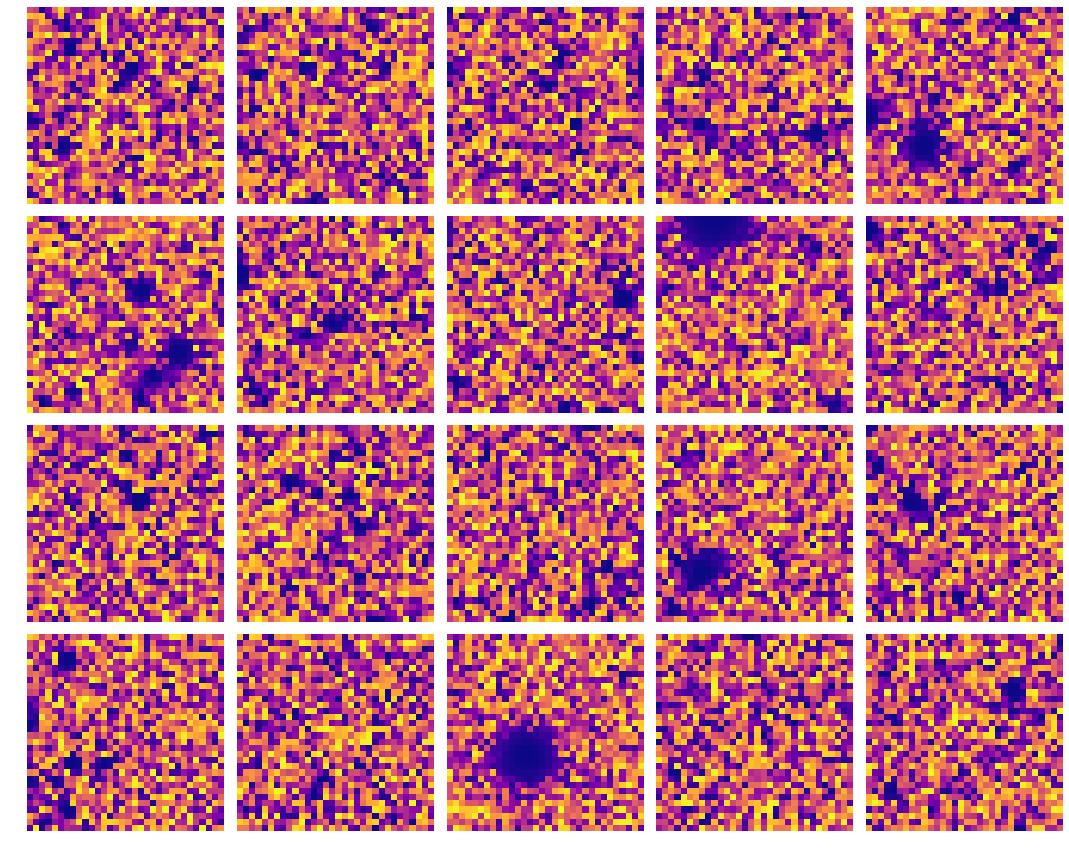

In [29]:
for i, batch in enumerate(train_loader):
    fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(15, 12))
    for img, ax in zip(batch['flux'].numpy(), axes.reshape(-1)):
        ax.imshow(equalize(img), interpolation='none', cmap='plasma_r')
        ax.axis('off')
    plt.tight_layout()
    break

## Weighted PCA

Adapted from [here](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Dimensionality.ipynb).

In [24]:
class WeightedPCA(object):
    """Implements the weighted PCA scheme of Delchambre 2015.
    
    See https://arxiv.org/abs/1412.4533 and the more complete implementation
    in https://github.com/jakevdp/wpca.
    """
    def __init__(self, n_components):
        self.n_components = n_components
        
    def prepare(self, X, ivar=None):
        if ivar is None:
            W = np.ones_like(X)
        else:
            assert np.all(ivar >= 0)
            W = np.sqrt(ivar)
        # Calculate the weighted mean of the data using eqn (2).
        self.mu = np.sum(W * X, axis=0) / np.sum(W, axis=0)
        # Subtract the weighted mean from the data.
        X = X - self.mu
        # Apply weights to the (mean subtracted) data.
        X *= W
        return X, W

    def fit(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        # Calculate the weighted covariance.
        C = np.dot(X.T, X)
        C /= np.dot(W.T, W)
        # Find the eigenvectors and eigenvalues of C.
        _, D = X.shape
        evals, evecs = scipy.linalg.eigh(C, eigvals=(D - self.n_components, D - 1))
        # Save the results.
        self.components_ = evecs[:, ::-1].T
        return self
        
    def transform(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        N, _ = X.shape
        Y = np.zeros((N, self.n_components))
        for i in range(N):
            cW = self.components_ * W[i]
            cWX = np.dot(cW, X[i])
            cWc = np.dot(cW, cW.T)
            Y[i] = np.linalg.solve(cWc, cWX)
        return Y
    
    def inverse_transform(self, X):
        return self.mu + np.dot(X, self.components_)

In [17]:
# Use scipy.linalg.eigh instead of np.linalg.eigh since it allows us to only
# find the eigenvectors with the largest eigenvalues.
import scipy.linalg

class WeightedPCA(object):
    """Implements the weighted PCA scheme of Delchambre 2015.
    
    See https://arxiv.org/abs/1412.4533 and the more complete implementation
    in https://github.com/jakevdp/wpca.
    """
    def __init__(self, n_components):
        self.n_components = n_components
        
    def prepare(self, X, ivar=None):
        if ivar is None:
            W = torch.ones_like(X)
        else:
            assert np.all(ivar >= 0)
            W = torch.sqrt(ivar)
        # Calculate the weighted mean of the data using eqn (2).
        self.mu = torch.sum(W * X, axis=0) / torch.sum(W, axis=0)
        # Subtract the weighted mean from the data.
        X = X - self.mu
        # Apply weights to the (mean subtracted) data.
        X *= W
        return X, W

    def fit(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        # Calculate the weighted covariance.
        C = torch.dot(X.T, X)
        C /= torch.dot(W.T, W)
        # Find the eigenvectors and eigenvalues of C.
        _, D = X.shape
        evals, evecs = scipy.linalg.symeig(C, eigvals=(D - self.n_components, D - 1))
        # Save the results.
        self.components_ = evecs[:, ::-1].T
        return self
        
    def transform(self, X, ivar=None):
        X, W = self.prepare(X, ivar)
        N, _ = X.shape
        Y = torch.zeros((N, self.n_components))
        for i in range(N):
            cW = self.components_ * W[i]
            cWX = torch.dot(cW, X[i])
            cWc = torch.dot(cW, cW.T)
            Y[i] = torch.linalg.solve(cWc, cWX)
        return Y
    
    def inverse_transform(self, X):
        return self.mu + torch.dot(X, self.components_)

In [27]:
def accumulate(loader, nbatches):
    done = 0
    X = []
    for batch in loader:
        X.append(batch.reshape(len(batch), -1))
        done += 1
        if done == nbatches:
            break
    X = torch.cat(X, dim=0).numpy()
    fit = WeightedPCA(n_components=8).fit(X)
        
accumulate(train_loader, 100)